## To do

- Agree on a title naming approach (e.g. do we keep "Laugh test X:", do we want to include the main reference in the title)
- Check the expectations for this laugh test and update the image accordingly
- Agree on what constitutes relevant meta data for these things
- Update results with Reza's new ones
- Do we want the code to be more elegant in terms of extracting length of data series, convert time from the .nc attributes etc?
- Image format and specs?

# Laugh test 6: Cryosuction processes in soil
This notebook plots SUMMA simulations for the test case defined in in Mizoguchi (1990, in Japanese, translated in Hansson et al., 2004).

## Expectations
The simulations should resemble data from Mizoguchi's laboratory experiments.

## Workflow
- Load model simulations (.nc) and lab data into memory
- Extract `mLayerVolFracLiq`, `mLayerVolFracIce` and `mLayerHeight` variables 
- Combine liquid and ice volumetric fractions into total volumetric water
- Create a plot of total volumetric water vs depth, for three different times since simulation start

## Meta data

| Data  | Value  |
|:---|:---|
| Model name| Structure for Unifying Multiple Modelling Alternatives (SUMMA) |
| Model version  |   |
| Model reference | Clark et al. (2015a,b) |
| Model runs by | M. Clark |
| Model decisions | see attributes in output.nc  |
| Model run date | see attributes in output.nc |
| Notebook code by | W. Knoben, A. Bennett |
    
## Reference(s)
Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Rasmussen, R. M. (2015a). A unified approach for process-based hydrologic modeling: 1. Modeling concept. Water Resources Research, 51(4), 2498–2514. https://doi.org/10.1002/2015WR017198

Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Marks, D. G. (2015b). A unified approach for process-based hydrologic modeling: 2. Model implementation and case studies. Water Resources Research, 51, 2515–2542. https://doi.org/10.1002/2015WR017200

Hansson, K., Šimůnek, J., Mizoguchi, M., Lundin, L. C., & Van Genuchten, M. T. (2004). Water flow and heat transport in frozen soil. Vadose Zone Journal, 3(2), 693-704.

Mizoguchi, M. 1990. Water, heat and salt transport in freezing soil. Ph.D. thesis. (In Japanese.) University of Tokyo.

In [1]:
# modules
from pathlib import Path
from matplotlib.ticker import MultipleLocator
import xarray as xr # note, also needs netcdf4 library installed
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Specify the data locations relative to the notebook
sim_path = Path("./output")
sim_file = 'mizoguchi1990_output_timestep.nc'
obs_path = Path('./evaluationData')
obs_file = 'mizoguchiLabData.txt'

In [3]:
# Load the data
ds = xr.open_dataset( sim_path / sim_file )
ld = np.loadtxt(fname = (obs_path / obs_file))

In [4]:
# The depths in the observations are in [mm], whereas those in summa are in [m]
# Depths in observations are also given as negative values, whereas SUMMA's are positive
# Convert observations data depths to be consistent with SUMMA
ld[:,0] = ld[:,0] / (-1000)

In [5]:
# Extract the variables we want
mLayerVolFracIce = ds.mLayerVolFracIce
mLayerVolFracLiq = ds.mLayerVolFracLiq
layerHeight = ds.mLayerHeight

In [6]:
# Combine liquid and ice into total
mLayerVolFracTot = mLayerVolFracLiq + mLayerVolFracIce

In [7]:
# Select the time slices of interest
mLayerVolFracTot_t720  = mLayerVolFracTot.isel(time=720)
mLayerVolFracTot_t1440 = mLayerVolFracTot.isel(time=1440)
mLayerVolFracTot_t3000 = mLayerVolFracTot.isel(time=3000)

layerHeight_t720  = layerHeight.isel(time=720)
layerHeight_t1440 = layerHeight.isel(time=1440)
layerHeight_t3000 = layerHeight.isel(time=3000)

In [8]:
# Define the layer depth until which we run the model (see test case specs)
idxDepth = 20 # layerHeight_t720[19] = 0.195m depth, layerHeight_t720[20] = -9999 depth 

In [9]:
# Ensure that we can actually read the figure labels
font = {'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

In [10]:
# Auxiliary function so we don't need to pollute the plotting code block
# Sets various axis properties that are constant for all three subplots
def set_axes_and_text(ix,ttl):

    # Flip y-axis
    ax[ix].invert_yaxis()
    
    # Axis limits
    ax[ix].set_xlim(0,0.5)
    
    # Tick spacing, placement, size
    ax[ix].set_yticks(np.arange(0,0.201,0.05)) # cheeky, but otherwise the 0.2 doesn't show up
    ax[ix].yaxis.set_minor_locator(MultipleLocator(0.01))
    ax[ix].xaxis.set_minor_locator(MultipleLocator(0.01))
    ax[ix].yaxis.set_ticks_position('both')
    ax[ix].xaxis.set_ticks_position('both')
    ax[ix].tick_params(which='major', length=12, direction='in')
    ax[ix].tick_params(which='minor', length=6, direction='in')
   
    # Labels
    ax[ix].set_xlabel('Total volumetric water [-]'); 
    ax[ix].set_ylabel('Depth [m]');
    ax[ix].legend();
    ax[ix].set_title(ttl);
    
    return



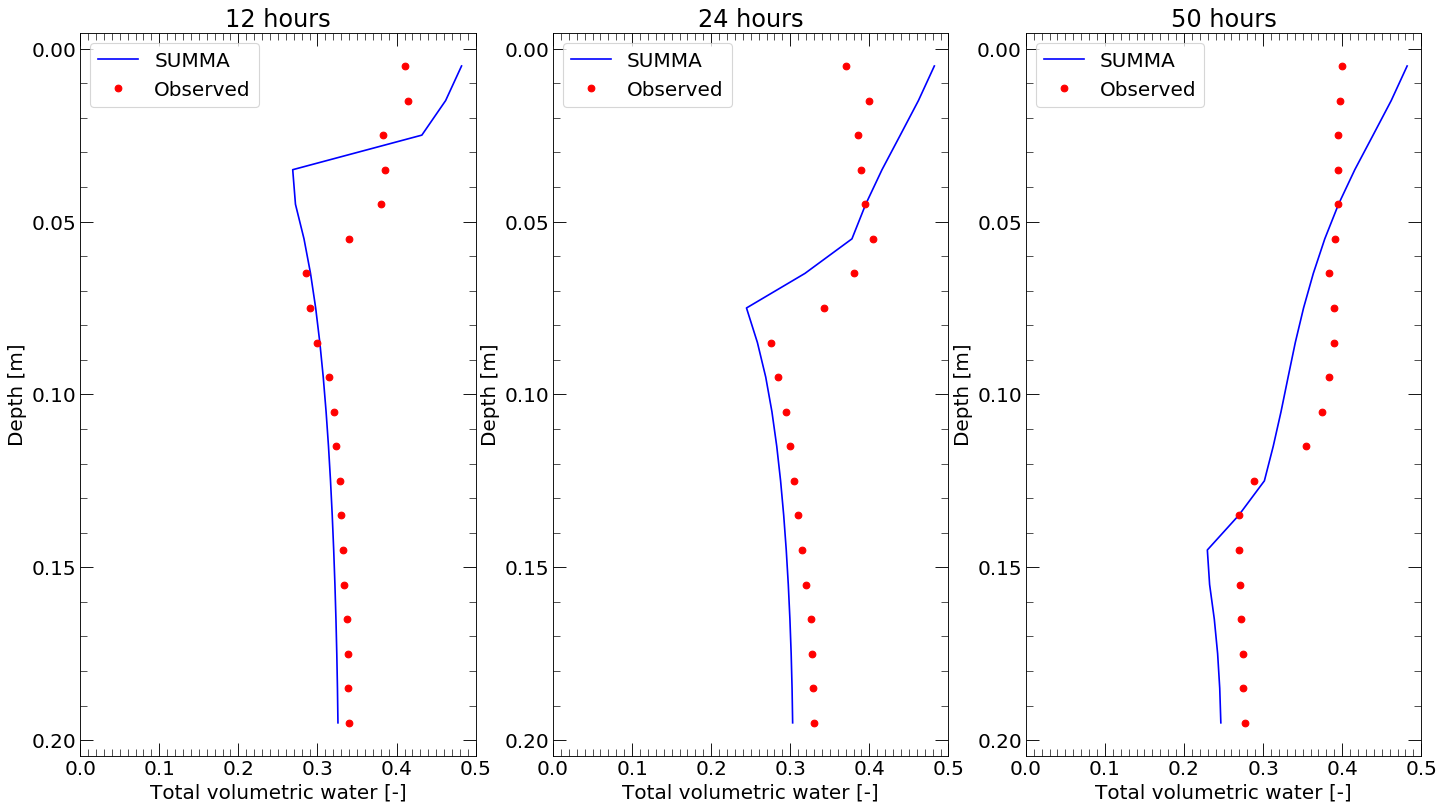

In [11]:
# Open a figure
fig, ax = plt.subplots(1,3, figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k');

# Switch to more spacious layout
fig.tight_layout()

# First case, t = 720
ax[0].plot(mLayerVolFracTot_t720[0:idxDepth], layerHeight_t720[0:idxDepth], color='blue', label='SUMMA');
ax[0].plot(ld[:,1], ld[:,0], linestyle='None', marker='o', color='red', label='Observed');
set_axes_and_text(0,'12 hours')

# Second case, t = 1440
ax[1].plot(mLayerVolFracTot_t1440[0:idxDepth], layerHeight_t1440[0:idxDepth], color='blue', label='SUMMA');
ax[1].plot(ld[:,2], ld[:,0], linestyle='None', marker='o', color='red', label='Observed');
set_axes_and_text(1,'24 hours')

# Third case, t = 3000
ax[2].plot(mLayerVolFracTot_t3000[0:idxDepth], layerHeight_t3000[0:idxDepth], color='blue', label='SUMMA');
ax[2].plot(ld[:,3], ld[:,0], linestyle='None', marker='o', color='red', label='Observed');
set_axes_and_text(2,'50 hours')

# Save 
plt.savefig('img/lt6_mizuguchi1990.png');